## Bad LR Performance
This notebook pokes at the results to try to figure out what is causing LR methods to do worse than random when the linear signal is removed

In [66]:
import collections
import glob
import itertools
import json
import os

import numpy as np
import pandas as pd
import sklearn.metrics
from plotnine import *

from saged.utils import split_sample_names, create_dataset_stat_df, get_dataset_stats, parse_map_file

In [3]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']
#top_five_tissues = ['Blood', 'Breast', 'Stem_Cell']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [4]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*signal_removed*.tsv'.format(pair[0], pair[1])))
len(in_files)

120

In [5]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    
    new_df['supervised'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['supervised'] = run_results['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
run_results

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,supervised,seed,tissue1,tissue2,correction_method,pair,train_count
0,0.686275,0.466817,0.811143,"SRP020561,SRP007461,SRP008746,SRP045500,SRP021...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",301,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",pytorch_lr,2,Blood,Breast,signal_removed,Blood-Breast,301
1,0.310588,0.393100,0.345495,"SRP020561,SRP007461,SRP008746,SRP045500,SRP041...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",602,0.2,"1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",pytorch_lr,2,Blood,Breast,signal_removed,Blood-Breast,602
2,0.425098,0.283464,0.594355,"SRP020561,SRP007461,SRP008746,SRP045500,SRP007...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",904,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",pytorch_lr,2,Blood,Breast,signal_removed,Blood-Breast,904
3,0.570196,0.378238,0.724900,"SRP019207,SRP020561,SRP007461,SRP019758,SRP008...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1205,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",pytorch_lr,2,Blood,Breast,signal_removed,Blood-Breast,1205
4,0.373333,0.251972,0.540012,"SRP019207,SRP020561,SRP007461,SRP019758,SRP008...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1507,0.5,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",pytorch_lr,2,Blood,Breast,signal_removed,Blood-Breast,1507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.390244,0.480000,0.000000,"SRP041471,SRP009144,SRP019270,SRP013825,SRP034...","SRR950087,SRR1521441,SRR1264075,SRR921552,SRR3...","SRR309282,SRR309283,SRR309284,SRR309289,SRR063...",523,0.6,"0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Brain"": 0, ""Cervix"": 1}",three_layer_net,2,Brain,Cervix,signal_removed,Brain-Cervix,523
46,0.373984,0.453699,0.049383,"SRP019270,SRP013825,SRP003672,SRP009247,SRP002...","SRR950087,SRR1521441,SRR1264075,SRR921552,SRR3...","SRR309282,SRR309283,SRR309284,SRR309289,SRR063...",610,0.7,"0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...","1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Brain"": 0, ""Cervix"": 1}",three_layer_net,2,Brain,Cervix,signal_removed,Brain-Cervix,610
47,0.390244,0.476849,0.025974,"SRP019270,SRP013825,SRP003672,SRP009247,SRP002...","SRR950087,SRR1521441,SRR1264075,SRR921552,SRR3...","SRR309282,SRR309283,SRR309284,SRR309289,SRR063...",697,0.8,"0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...","1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Brain"": 0, ""Cervix"": 1}",three_layer_net,2,Brain,Cervix,signal_removed,Brain-Cervix,697
48,0.308943,0.370548,0.065934,"SRP019270,SRP013825,SRP003672,SRP009247,SRP002...","SRR950087,SRR1521441,SRR1264075,SRR921552,SRR3...","SRR309282,SRR309283,SRR309284,SRR309289,SRR063...",784,0.9,"0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...","1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Brain"": 0, ""Cervix"": 1}",three_layer_net,2,Brain,Cervix,signal_removed,Brain-Cervix,784


In [8]:
run_results['val_encoders'].value_counts()

{"Blood": 0, "Brain": 1}         600
{"Blood": 0, "Cervix": 1}        600
{"Brain": 0, "Breast": 1}        600
{"Blood": 0, "Stem Cell": 1}     600
{"Blood": 0, "Breast": 1}        600
{"Breast": 0, "Cervix": 1}       600
{"Breast": 0, "Stem Cell": 1}    600
{"Cervix": 0, "Stem Cell": 1}    600
{"Brain": 0, "Stem Cell": 1}     550
{"Brain": 0, "Cervix": 1}        550
Name: val_encoders, dtype: int64

In [27]:
sample_model_predictions = {}
model_predictions = {}
# Process dataframe rows
for i, row in run_results.iterrows():
    model = row['supervised']
    
    if model not in model_predictions:
        model_predictions[model] = {'predicted': [], 'true': []}
    
    encoder_string = row['val_encoders']
    try:
        encoder = json.loads(encoder_string)
    except TypeError:
        continue
    decoder = {number: label for label, number in encoder.items()}
    
    samples = row['val samples'].strip().split(',')
    
    predictions = row['val_predictions'].strip().split(',')
    truth = row['val_true_labels'].strip().split(',')
    pred_labels = []
    
    for prediction in predictions:
        if int(prediction) in decoder:
            pred_labels.append(decoder[int(prediction)])
        else:
            # https://github.com/greenelab/saged/issues/58
            pred_labels.append('invalid_index')
            
    predictions = pred_labels
    
    truth = [decoder[int(t)] for t in truth]
    
    assert len(truth) == len(predictions)
    
    model_predictions[model]['predicted'].extend(predictions)
    model_predictions[model]['true'].extend(truth)
    
    for sample, prediction, true_label in zip(samples, predictions, truth):
        if sample not in sample_model_predictions:
            sample_model_predictions[sample] = {}
        if model not in sample_model_predictions[sample]:
            sample_model_predictions[sample][model] = {'correct': 0, 'total': 0, 
                                                       'predictions': [], 'true_label': true_label}
        
        assert sample_model_predictions[sample][model]['true_label'] == true_label
        
        sample_model_predictions[sample][model]['predictions'].append(prediction)
        sample_model_predictions[sample][model]['total'] += 1
        
        correct = (prediction == true_label)
        if correct:
            sample_model_predictions[sample][model]['correct'] += 1

accuracy                                                          0.368613
balanced_accuracy                                                      0.5
f1_score                                                                 0
train studies            SRP002079,SRP017972,SRP034606,SRP016568,SRP015...
train samples            SRR531466,SRR1044676,SRR1220432,SRR1268168,SRR...
val samples              SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...
train sample count                                                      79
fraction of data used                                                  0.1
val_predictions                                                        NaN
val_true_labels                                                        NaN
val_encoders                                                           NaN
supervised                                                        deep_net
seed                                                                     2
tissue1                  

In [39]:
def row_norm(row):
    new_row = row / row.sum()
    return new_row

def create_confusion_df(model_predictions, model, norm=True):
    predicted = model_predictions[model]['predicted']
    true = model_predictions[model]['true']

    confusion_matrix = sklearn.metrics.confusion_matrix(true, predicted)
    
    tissue_set = set(true).union(set(predicted))
    tissues = sorted(list(tissue_set))
    
    if norm:
        confusion_matrix = np.apply_along_axis(row_norm, axis=1, arr=confusion_matrix)
    confusion_df = pd.DataFrame(confusion_matrix, index = [l for l in tissues],
                                columns = [l for l in tissues])
    
    confusion_df['true_tissue'] = confusion_df.index
    confusion_df = confusion_df.dropna()
    return confusion_df

In [47]:
confusion_df = create_confusion_df(model_predictions, 'deep_net', norm=True)

In [50]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

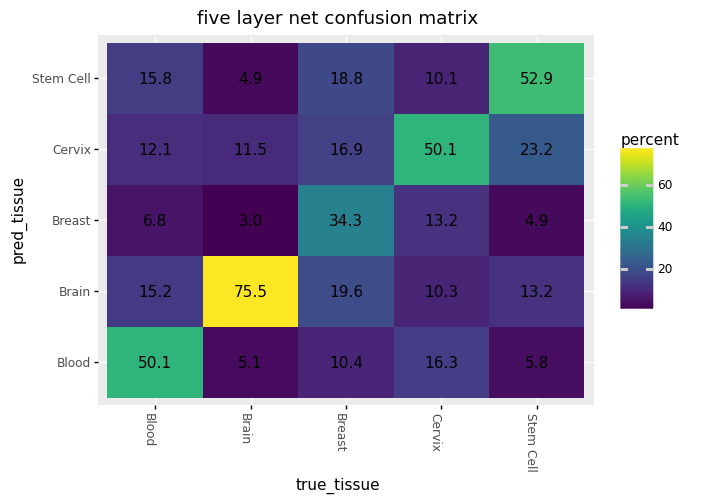

<ggplot: (8769500214813)>

In [54]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'))
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('five layer net confusion matrix')
plot

In [78]:
confusion_df = create_confusion_df(model_predictions, 'three_layer_net', norm=True)

In [79]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

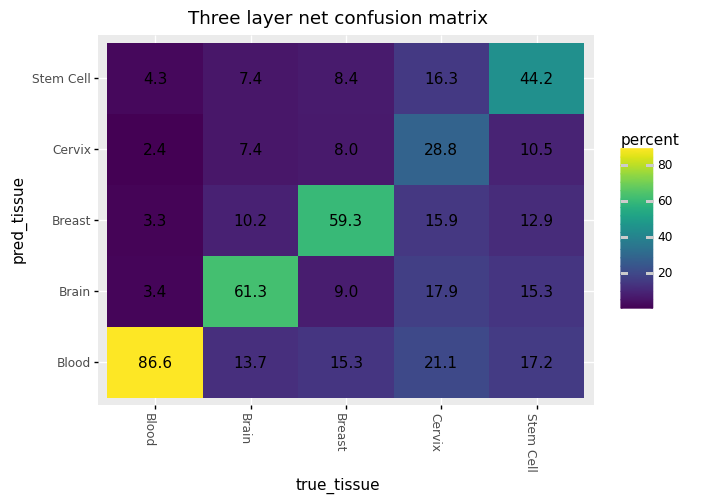

<ggplot: (8769497536577)>

In [80]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'))
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Three layer net confusion matrix')
plot

In [81]:
confusion_df = create_confusion_df(model_predictions, 'pytorch_lr', norm=True)

In [82]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

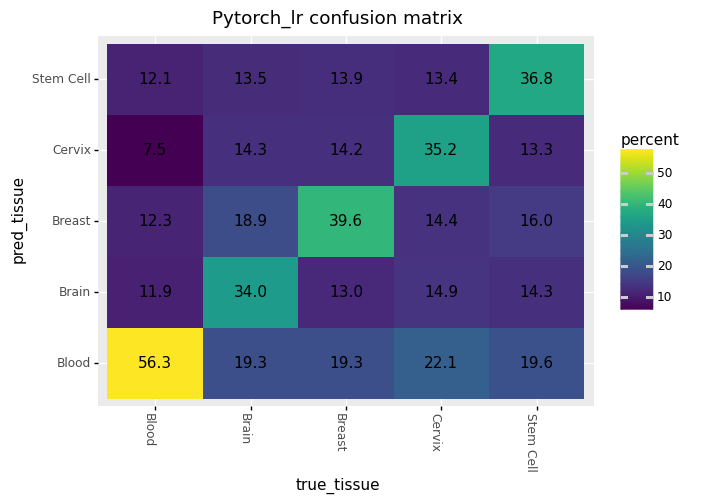

<ggplot: (8769497474925)>

In [83]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'))
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Pytorch_lr confusion matrix')
plot

In [62]:
confusion_df = create_confusion_df(model_predictions, 'logistic_regression', norm=True)

In [63]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

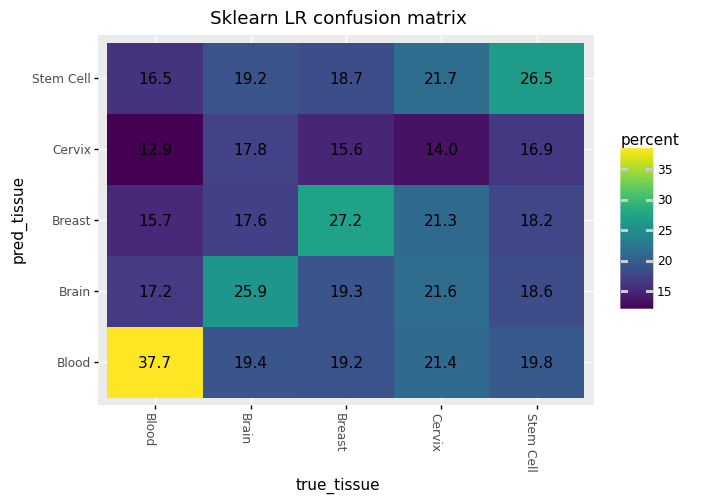

<ggplot: (8769500359161)>

In [64]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'))
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Sklearn LR confusion matrix')
plot

## Prediction distributions

In [92]:
deep_net_predicted = collections.Counter(model_predictions['deep_net']['predicted'])
deep_net_true = predicted = collections.Counter(model_predictions['deep_net']['true'])
print(deep_net_predicted, deep_net_true)

Counter({'Blood': 326758, 'Brain': 175377, 'Stem Cell': 164996, 'Cervix': 148439, 'Breast': 95960}) Counter({'Blood': 591240, 'Breast': 120720, 'Stem Cell': 74360, 'Cervix': 65010, 'Brain': 60200})


In [93]:
three_layer_net_predicted = collections.Counter(model_predictions['three_layer_net']['predicted'])
three_layer_net_true = predicted = collections.Counter(model_predictions['three_layer_net']['true'])
print(three_layer_net_predicted, three_layer_net_true)

Counter({'Blood': 569113, 'Breast': 120215, 'Brain': 100156, 'Stem Cell': 88472, 'Cervix': 58284}) Counter({'Blood': 591240, 'Breast': 120720, 'Stem Cell': 81120, 'Brain': 72240, 'Cervix': 70920})


In [94]:
pytorch_lr_predicted = collections.Counter(model_predictions['pytorch_lr']['predicted'])
pytorch_lr_true = predicted = collections.Counter(model_predictions['pytorch_lr']['true'])
print(pytorch_lr_predicted, pytorch_lr_true)

Counter({'Blood': 401363, 'Breast': 157114, 'Stem Cell': 137343, 'Brain': 132898, 'Cervix': 107522}) Counter({'Blood': 591240, 'Breast': 120720, 'Stem Cell': 81120, 'Brain': 72240, 'Cervix': 70920})


In [95]:
skl_lr_predicted = collections.Counter(model_predictions['logistic_regression']['predicted'])
skl_lr_true = predicted = collections.Counter(model_predictions['logistic_regression']['true'])
print(skl_lr_predicted, skl_lr_true)

Counter({'Blood': 291140, 'Brain': 174124, 'Stem Cell': 170858, 'Breast': 168383, 'Cervix': 131735}) Counter({'Blood': 591240, 'Breast': 120720, 'Stem Cell': 81120, 'Brain': 72240, 'Cervix': 70920})


In [101]:
pred_df = pd.DataFrame([deep_net_predicted, three_layer_net_predicted, pytorch_lr_predicted, skl_lr_predicted])
pred_df['model'] = ['five_layer_net', 'three_layer_net', 'pytorch_lr', 'skl_lr']
pred_df['pred_or_true'] = 'pred'
pred_df

,Blood,Breast,Stem Cell,Cervix,Brain,model,pred_or_true
0,326758,95960,164996,148439,175377,five_layer_net,pred
1,569113,120215,88472,58284,100156,three_layer_net,pred
2,401363,157114,137343,107522,132898,pytorch_lr,pred
3,291140,168383,170858,131735,174124,skl_lr,pred


In [102]:
true_df = pd.DataFrame([deep_net_true, three_layer_net_true, pytorch_lr_true, skl_lr_true])
true_df['model'] = ['five_layer_net', 'three_layer_net', 'pytorch_lr', 'skl_lr']
true_df['pred_or_true'] = 'true'
true_df

,Blood,Breast,Stem Cell,Cervix,Brain,model,pred_or_true
0,591240,120720,74360,65010,60200,five_layer_net,true
1,591240,120720,81120,70920,72240,three_layer_net,true
2,591240,120720,81120,70920,72240,pytorch_lr,true
3,591240,120720,81120,70920,72240,skl_lr,true


In [106]:
all_df = pd.concat([pred_dict, true_dict])
all_df

,Blood,Breast,Stem Cell,Cervix,Brain,model,pred_or_true
0,326758,95960,164996,148439,175377,five_layer_net,pred
1,569113,120215,88472,58284,100156,three_layer_net,pred
2,401363,157114,137343,107522,132898,pytorch_lr,pred
3,291140,168383,170858,131735,174124,skl_lr,pred
0,591240,120720,74360,65010,60200,five_layer_net,true
1,591240,120720,81120,70920,72240,three_layer_net,true
2,591240,120720,81120,70920,72240,pytorch_lr,true
3,591240,120720,81120,70920,72240,skl_lr,true


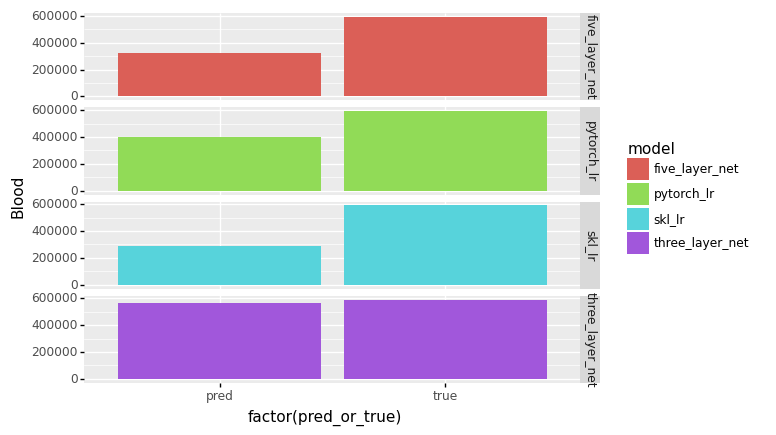

<ggplot: (8769497328101)>


In [120]:
plot = ggplot(all_df, aes(x='factor(pred_or_true)', y='Blood', fill='model'))
plot += geom_bar(stat='identity')
plot += facet_grid('model ~ .')
print(plot)

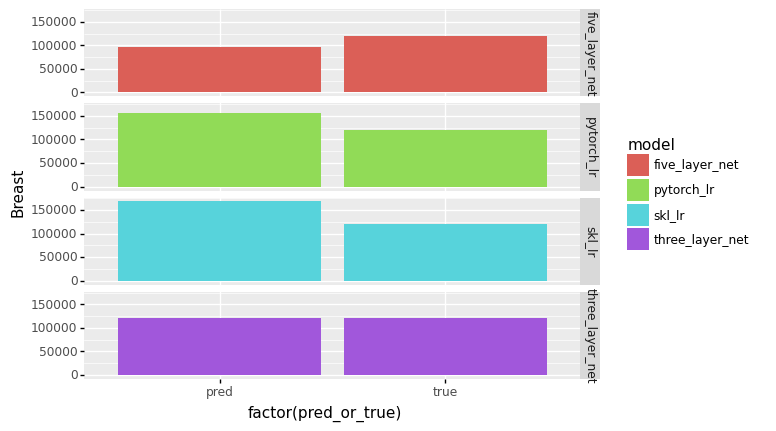

<ggplot: (8769499774741)>


In [121]:
plot = ggplot(all_df, aes(x='factor(pred_or_true)', y='Breast', fill='model'))
plot += geom_bar(stat='identity')
plot += facet_grid('model ~ .')
print(plot)

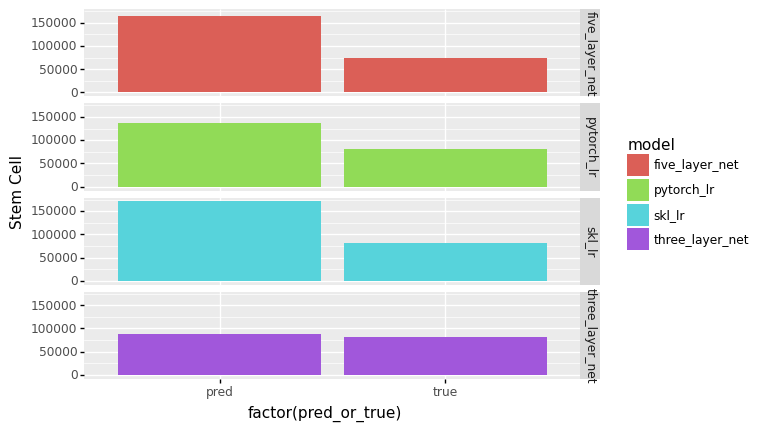

<ggplot: (8769500227949)>


In [122]:
plot = ggplot(all_df, aes(x='factor(pred_or_true)', y='Stem Cell', fill='model'))
plot += geom_bar(stat='identity')
plot += facet_grid('model ~ .')
print(plot)

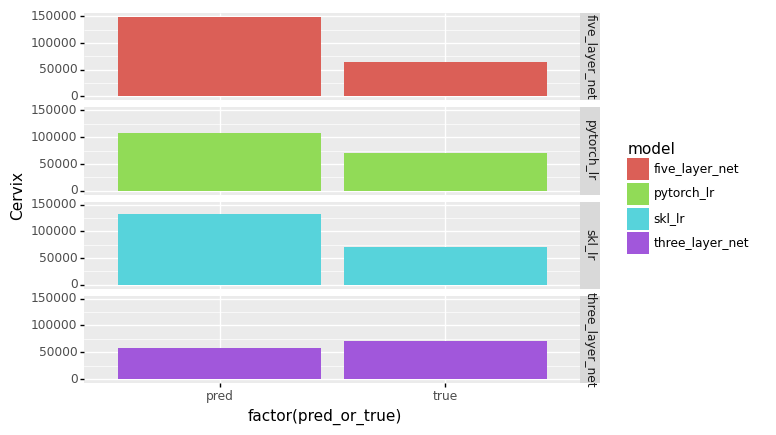

<ggplot: (8769500376889)>


In [123]:
plot = ggplot(all_df, aes(x='factor(pred_or_true)', y='Cervix', fill='model'))
plot += geom_bar(stat='identity')
plot += facet_grid('model ~ .')
print(plot)

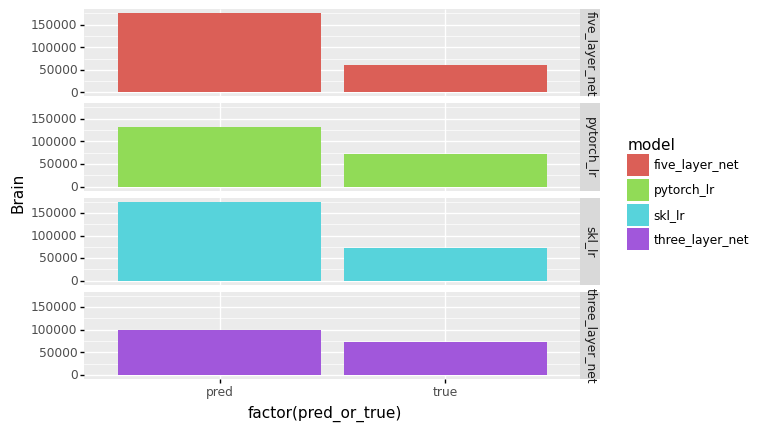

<ggplot: (8769497196365)>


In [124]:
plot = ggplot(all_df, aes(x='factor(pred_or_true)', y='Brain', fill='model'))
plot += geom_bar(stat='identity')
plot += facet_grid('model ~ .')
print(plot)

## Conclusion
There doesn't seem to be anything significantly different between the prediction distributions of the deep models and the linear models. The linear ones are just wrong more regardless of class.

Actually the differences between the five layer net and three layer net in terms of their prediction strategy are interesting (they perform better with respect to different classes).

My working hypothesis is now that the linear models are learning spurious correlations in the training set that cause them to overfit the test set